# Regression with Neural Networks

In [54]:
import os
import sys

current_path = os.getcwd()
sys.path.append(current_path + '\..')


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

# Import self-made modules
from project2_code import *

### Make and prepare data

In [6]:
n = 1000
np.random.seed(1)
x = 10*np.random.rand(n)

# Make second degree polynomial
y = 2 + 5*x + x**2

# Create design matrix, up to second degree
X = create_design_matrix_1d(x, 2)

# Split in train, validation and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=1)

# Scale the data
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [85]:
import numpy as np
from sklearn.utils import shuffle
from project2_code import gradient_descent, stochastic_gradient_descent, cost_linear, cross_entropy
from project2_code import sigmoid, sigmoid_derivative, relu, relu_derivative, relu_leaky, relu_leaky_derivative
from project2_code import MSE, R2, accuracy

class NeuralNetwork:

    """
    A class to build a Neural Network. The network is trained using forward and backward propagation.
    The network can be used both for classification and for regression

    Attributes
    ----
       num_features (int): number of features in input data. Needed to build first layer
       regr_or_class (string): 'regr' if regression (default) and 'class' if classification
       activation (string): activation function to use, default is 'sigmoid'
    
    """
    def __init__(self, num_features, regr_or_class='regr', activation = 'sigmoid'):
        self.num_features = num_features
        self.weights = {}  # Dictionary to store weights for each layer
        self.biases = {} # Dictionary to store biases
        self.activations = {} # Dictionary to store input for each layer
        self.errors = {} # Store errors
        # Check if we're doing regression or classification
        self.learning_type = regr_or_class
        # Check what activation function to use
        if activation == 'sigmoid':
            self.activation_function = sigmoid
            self.activation_prime = sigmoid_derivative
        elif activation == 'relu':
            self.activation_function = relu
            self.activation_prime = relu_derivative
        elif activation == 'leakyrelu':
            self.activation_function = relu_leaky
            self.activation_prime = relu_leaky_derivative
        
    def initialize_weights(self, size_layer, size_prev_layer):
        """
        Initializes weights by drawing from a gaussian distribution.
        
        Input
        ------
        size_prev_layer (int): number of nodes in previous layer
        size_layer (int): number of nodes in this layer
        
        Returns
        --------
        2d array of size size_prev_layer x size_layer
        """
        return np.random.randn(size_prev_layer, size_layer) 
    
    def initialize_bias(self, size_layer):
        """
        Initializes biases for all nodes by drawing a random number between 0 and 1
        
        Input
        ------
        size_layer (int): number of nodes in this layer
        
        Returns
        --------
        1d array of size size_layer
        """
        return np.random.rand(size_layer)
        
    def add_layer(self, size_layer):
        """
        Adds layer of size 'size_layer' to the network. Initializes weights and biases for all layers.
        
        Input
        ------
        size_layer (int): number of nodes in this layer
        
        Returns
        --------
        None
        """
        # Check if this is first layer
        if len(self.weights) == 0:
            self.weights[0] = self.initialize_weights(size_layer, self.num_features)
            self.biases[0] = self.initialize_bias(size_layer)
        else:
            counter = len(self.weights)
            size_prev_layer = self.weights[counter - 1].shape[1]
            self.weights[counter] = self.initialize_weights(size_layer, size_prev_layer)
            self.biases[counter] = self.initialize_bias(size_layer)
            
    def compute_z(self, current_layer):
        """
        Computes the weighted sum inputs @ weights and add bias.
        """
        #Get weights and bias for current layer
        weights = self.weights.get(current_layer)
        bias = self.biases.get(current_layer)
        #Get input data for current layer
        inputs = self.activations.get(current_layer)
        #Calculate weighted sum of input and add bias
        z = inputs @ weights + bias
        return z
            
    def forward_prop(self):
        """
        Propagates the input through all layers.
        For each layer the function gets the layer weights and input data from the weights and activations dictionaries.
        The code calculates the matrix product weights @ inputs and adds the bias.
        An activation function is used to get the output, and the output is stored to be used as input for the next layer,
        or as the final output for the final layer.
        """
        current_layer = 0
        num_layers = len(self.weights)
        # Loop through all layers
        while current_layer < num_layers:
            # Find z
            z = self.compute_z(current_layer)
            # Check if we are on last layer
            # If last layer check if we are doing classification or regression
            # If regression use a linear activation function for last layer
            # If classification use the sigmoid function
            # Use the activation function for other layers
            if current_layer == num_layers - 1:
                if self.learning_type == 'class':
                    a = sigmoid(z)
                else:
                    a = z
            else:
                a = self.activation_function(z)
            #Store output to use as input for next layer
            current_layer += 1
            self.activations[current_layer] = a

    def back_prop(self, y):
        """
        Propagates the error backwards through all layers. Finds first error for last layer using error from cost function.
        Error is then propagated backwards untill first layer is reached. The function updates the error dictionary.
        """
        # Start with last layer
        current_layer = len(self.weights)
        # Get output for last layer
        a = self.activations.get(current_layer).ravel()
        # Derivative of cost function for MSE
        C_deriv = (a - y).reshape(-1, 1)
        # Get derivative of activation function used in last layer
        z = self.compute_z(current_layer-1)
        if self.learning_type == 'regr':
            activation_deriv = np.ones((len(z), 1))
        elif self.learning_type == 'class':
            activation_deriv = sigmoid_derivative(z)
        output_error = C_deriv * activation_deriv
        # Store error for last layer
        self.errors[current_layer] = output_error
        current_layer -= 1
        # Loop through all layers
        while current_layer > 0:
            error_prev = self.errors[current_layer + 1]
            weights = self.weights[current_layer]
            z = self.compute_z(current_layer-1)
            activation_deriv = self.activation_prime(z)
            # Find error for current layer
            error = np.dot(error_prev, weights.T) * activation_deriv
            # Store error
            self.errors[current_layer] = error
            current_layer -= 1
            
    def update_weights(self, learning_rate, reg_coef):
        """
        Updates weight based on error from backpropagation.
        """
        current_layer = 0
        while current_layer < len(self.weights):
            activations = self.activations[current_layer]
            error = self.errors[current_layer + 1]
            self.weights[current_layer] = self.weights[current_layer] - learning_rate*np.dot(activations.T, error)
            self.biases[current_layer] = self.biases[current_layer] - learning_rate*np.sum(error, axis=0)
            current_layer += 1
        
    def train(self, data, target, num_epochs = 100, minibatches = 1, learning_rate = 0.01, reg_coef = 0, return_loss=False, loss='MSE', data_val=None, target_val=None): 
        """
        This function trains the network. For every epoch the input is propagated through the network to get the
        final output, and the error is propagated backwards. The weights are updated. This is repeated for num_epochs iterations.
        
        Input 
        -------
        data (dataframe / array): input data
        target (array): target
        num_epochs (int): number of epochs to train the network with forward and backward propagation
        minibatches (int): number of batches
        learning_rate (float): learning rate for gradient descent
        return_loss (bool): whether to return the train and validation loss for all epochs
        loss (string): which loss function to use if returning loss
        data_val (dataframe / array): input validation data
        target_val (array): validation target
        """
        # Find size of each minibatch
        n = len(data)  # number of rows
        batch_size = int(n/minibatches)
        
        # Create empty list for loss of return_loss
        if return_loss:
            self.loss_train = []
            self.loss_val = []
        
        for i in range(num_epochs):
            # Shuffle data
            data_shuffle, target_shuffle = shuffle(data, target)
            # Choose random batch
            batch_chosen = np.random.randint(0, minibatches)
            data_minibatch = data_shuffle[batch_chosen:batch_chosen+batch_size]
            target_minibatch = target_shuffle[batch_chosen:batch_chosen+batch_size]
            # Set minibatch data as input to first layer
            self.activations[0] = data_minibatch
            # Get output by using feed forward
            self.forward_prop()
            # Propagate error using back propagation
            self.back_prop(target_minibatch)
            # Update the weights
            self.update_weights(learning_rate, reg_coef)
            
            if return_loss:
                target_pred_val = self.predict(data_val)
                if loss == 'MSE':
                    val_loss = MSE(target_pred_val, target_val)
                elif loss == 'R2':
                    val_loss = R2(target_pred_val, target_val)
                elif loss == 'accuracy':
                    val_loss = accuracy(target_pred_val, target_val)
                    
                target_pred_train = self.predict(data)
                if loss == 'MSE':
                    train_loss = MSE(target_pred_train, target)
                elif loss == 'R2':
                    train_loss = R2(target_pred_train, target)
                elif loss == 'accuracy':
                    train_loss = accuracy(target_pred_train, target)
                
                self.loss_val.append(val_loss)
                self.loss_train.append(train_loss)
                
                
    def predict(self, x):
        """
        Predicts the output of new data.
        Works for both classification (output is categorical) and regression (output is continuous)
        """
        # Set input data
        self.activations[0] = x
        # Propagate input
        self.forward_prop()
        preds = self.activations[len(self.activations) - 1].ravel()
        if self.learning_type == 'class':
            return np.where(preds >= 0.5, 1, 0)
        return preds
    
    def predict_proba(self, x):
        """
        Predicts probability of each class. Used for classification
        """
        self.forward_prop(x)
        preds = self.activations[len(self.activations) - 1]
        return preds

In [120]:
network = NeuralNetwork(X_train_scaled.shape[1])        
network.add_layer(8)
network.add_layer(1)
 
network.train(X_train_scaled, y_train, minibatches=2, num_epochs = 2000, learning_rate=0.0001,return_loss=True, loss='MSE', data_val=X_val_scaled, target_val=y_val, reg_coef=0.5)
y_pred = network.predict(X_train_scaled)
MSE(y_pred, y_train)

0.27877786789643616

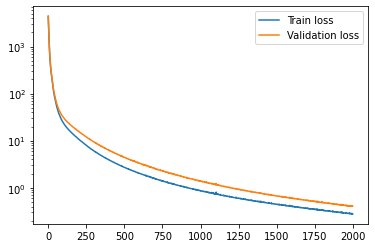

In [121]:
plt.plot(range(2000), network.loss_train, label='Train loss')
plt.plot(range(2000), network.loss_val, label='Validation loss')
plt.legend()
plt.yscale('log')

In [73]:
regr = MLPRegressor(hidden_layer_sizes=(8,), max_iter=2000, activation='logistic', solver='sgd', learning_rate_init=0.0001)
regr.fit(X_train_scaled, y_train)
y_pred = regr.predict(X_train_scaled)
MSE(y_pred, y_train)

C:\Users\odala\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


8.475528516380786

In [105]:
regr = MLPRegressor(hidden_layer_sizes=(8,), max_iter=2000, activation='relu', solver='sgd', learning_rate_init=0.00001)
regr.fit(X_train_scaled, y_train)
y_pred = regr.predict(X_train_scaled)
MSE(y_pred, y_train)

C:\Users\odala\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


1.7414283750303663

In [106]:
y_pred_test = network.predict(X_test_scaled)
MSE(y_pred_test, y_test)

0.8662210817784584

In [118]:
network = NeuralNetwork(X_train_scaled.shape[1], activation='relu')        
network.add_layer(8)
network.add_layer(1)
 
network.train(X_train_scaled, y_train, minibatches=2, num_epochs = 20000, learning_rate=0.00001, return_loss=True, loss='MSE', data_val=X_val_scaled, target_val=y_val, reg_coef=0.5)
y_pred = network.predict(X_train_scaled)
MSE(y_pred, y_train)

0.00019888940481527676

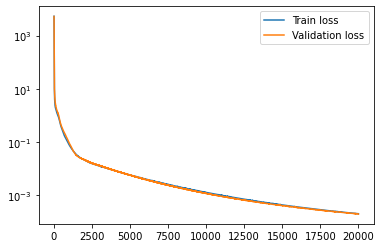

In [119]:
plt.plot(range(20000), network.loss_train, label='Train loss')
plt.plot(range(20000), network.loss_val, label='Validation loss')
plt.legend()
plt.yscale('log')

In [103]:
network = NeuralNetwork(X_train_scaled.shape[1], activation='leakyrelu')        
network.add_layer(8)
network.add_layer(1)
 
network.train(X_train_scaled, y_train, minibatches=5, num_epochs = 2000, learning_rate=0.00001, return_loss=True, loss='MSE', data_val=X_val_scaled, target_val=y_val, reg_coef=0.5)
y_pred = network.predict(X_train_scaled)
MSE(y_pred, y_train)

0.599217934576566

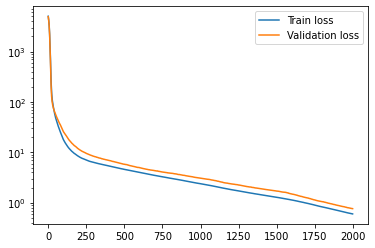

In [104]:
plt.plot(range(2000), network.loss_train, label='Train loss')
plt.plot(range(2000), network.loss_val, label='Validation loss')
plt.legend()
plt.yscale('log')